In [20]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2

# 设置数据根目录
DATA_ROOT = 'data'

print(f"Data root: {os.path.abspath(DATA_ROOT)}")

Data root: /home/jebediahc/tum/seminar-rs/data


In [21]:
def count_files(directory, extension="*.tif"):
    counts = {}
    for root, dirs, files in os.walk(directory):
        # 只统计 image 目录下的文件，忽略 label
        if 'image' in root:
            tif_files = glob.glob(os.path.join(root, extension))
            if tif_files:
                # 获取相对路径作为 key，例如 'gf-7-building-3bands/Train/image'
                rel_path = os.path.relpath(root, DATA_ROOT)
                counts[rel_path] = len(tif_files)
    return counts

datasets = ['gf-7-building-3bands', 'gf-7-building-4bands']
total_stats = {}

for ds in datasets:
    ds_path = os.path.join(DATA_ROOT, ds)
    if os.path.exists(ds_path):
        print(f"Scanning {ds}...")
        stats = count_files(ds_path)
        total_stats.update(stats)
    else:
        print(f"Dataset {ds} not found.")

print("\n--- 数据集统计结果 ---")
for path, count in total_stats.items():
    print(f"{path}: {count} images")


Scanning gf-7-building-3bands...
Scanning gf-7-building-4bands...

--- 数据集统计结果 ---
gf-7-building-3bands/Val/image: 1034 images
gf-7-building-3bands/Test/image: 1035 images
gf-7-building-3bands/Train/image: 3106 images
gf-7-building-4bands/Val/image: 1034 images
gf-7-building-4bands/Test/image: 1035 images
gf-7-building-4bands/Train/image: 3106 images


In [22]:
def get_sample_pair(dataset_name, split='Train'):
    image_dir = os.path.join(DATA_ROOT, dataset_name, split, 'image')
    label_dir = os.path.join(DATA_ROOT, dataset_name, split, 'label')

    search_path = os.path.join(image_dir, '*.tif')
    files = glob.glob(search_path)

    if files:
        # Pick a sample, e.g., the 11th file
        img_path = files[100]
        filename = os.path.basename(img_path)
        lbl_path = os.path.join(label_dir, filename)

        if not os.path.exists(lbl_path):
            print(f"Label not found for {filename}")
            lbl_path = None

        return img_path, lbl_path
    return None, None

# 获取 3bands 和 4bands 的样本
sample_3band_img, sample_3band_lbl = get_sample_pair('gf-7-building-3bands')
sample_4band_img, sample_4band_lbl = get_sample_pair('gf-7-building-4bands')

def inspect_image(file_path, is_label=False):
    if not file_path:
        print("File path is None.")
        return None

    type_str = "Label" if is_label else "Image"
    print(f"\nInspecting {type_str}: {file_path}")
    try:
        # 使用 skimage 读取
        img = io.imread(file_path)
        print(f"Shape: {img.shape}")
        print(f"Dtype: {img.dtype}")
        print(f"Min: {img.min()}, Max: {img.max()}")
        return img
    except Exception as e:
        print(f"Error reading {type_str}: {e}")
        return None

img_3b = inspect_image(sample_3band_img)
lbl_3b = inspect_image(sample_3band_lbl, is_label=True)

img_4b = inspect_image(sample_4band_img)
lbl_4b = inspect_image(sample_4band_lbl, is_label=True)


Inspecting Image: data/gf-7-building-3bands/Train/image/Ningbo_322.tif
Shape: (512, 512, 3)
Dtype: uint8
Min: 8, Max: 212

Inspecting Label: data/gf-7-building-3bands/Train/label/Ningbo_322.tif
Shape: (512, 512)
Dtype: uint8
Min: 0, Max: 255

Inspecting Image: data/gf-7-building-4bands/Train/image/Ningbo_322.tif
Shape: (512, 512, 4)
Dtype: uint8
Min: 0, Max: 212

Inspecting Label: data/gf-7-building-4bands/Train/label/Ningbo_322.tif
Shape: (512, 512)
Dtype: uint8
Min: 0, Max: 255


Visualizing 3-band image with label:


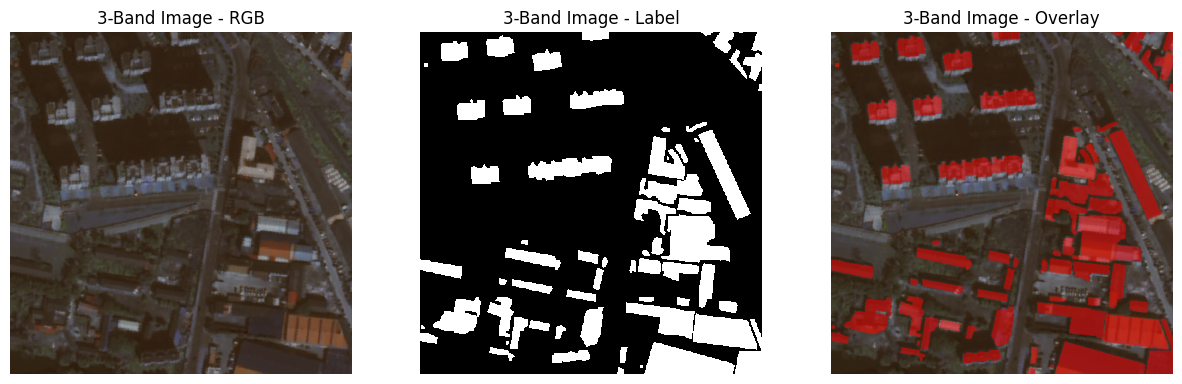

Visualizing 4-band image with label:


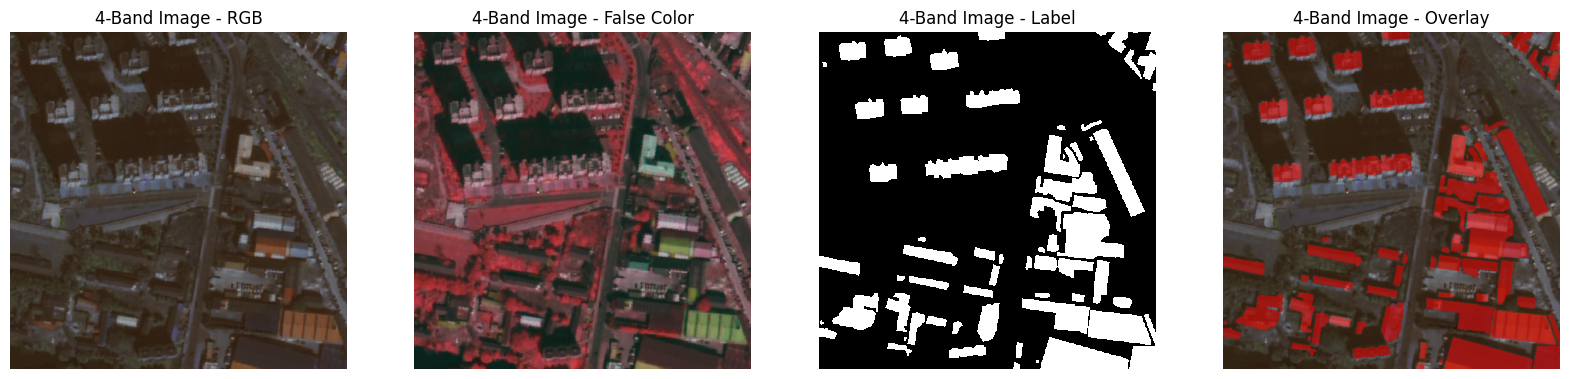

In [23]:
def visualize_image(img, label=None, title="Image"):
    if img is None:
        return

    plots = []
    img_rgb_display = None # For overlay

    # Prepare Image Plots
    if len(img.shape) == 3:
        # RGB (Bands 1-3)
        if img.dtype == np.uint16:
            # Min-Max Normalization for display
            img_vis = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
        else:
            img_vis = img

        img_rgb_display = img_vis[:, :, :3]
        plots.append((img_rgb_display, f"{title} - RGB"))

        # False Color (NIR, R, G) if 4 bands
        if img.shape[2] >= 4:
            nir = img[:, :, 3]
            r = img[:, :, 0]
            g = img[:, :, 1]
            def normalize(band):
                return ((band - band.min()) / (band.max() - band.min() + 1e-8) * 255).astype(np.uint8)
            false_color = np.stack([normalize(nir), normalize(r), normalize(g)], axis=2)
            plots.append((false_color, f"{title} - False Color"))
    else:
        # Grayscale
        plots.append((img, f"{title} - Gray"))
        # Convert to RGB for overlay
        if img.dtype == np.uint16:
             norm_img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
        else:
             norm_img = img
        img_rgb_display = np.stack([norm_img]*3, axis=-1)

    # Prepare Label Plot
    if label is not None:
        plots.append((label, f"{title} - Label"))

        # Overlay Plot
        if img_rgb_display is not None:
            overlay = img_rgb_display.copy().astype(float)
            mask = label > 0
            # Red overlay with alpha 0.5
            red_color = np.array([255, 0, 0])
            alpha = 0.5
            overlay[mask] = overlay[mask] * (1 - alpha) + red_color * alpha
            plots.append((overlay.astype(np.uint8), f"{title} - Overlay"))

    # Plotting
    plt.figure(figsize=(5 * len(plots), 5))
    for i, (data, name) in enumerate(plots):
        plt.subplot(1, len(plots), i + 1)
        if len(data.shape) == 2:
            # Label or Grayscale
            plt.imshow(data, cmap='gray', interpolation='nearest')
        else:
            plt.imshow(data)
        plt.title(name)
        plt.axis('off')

    plt.show()

print("Visualizing 3-band image with label:")
visualize_image(img_3b, lbl_3b, "3-Band Image")

print("Visualizing 4-band image with label:")
visualize_image(img_4b, lbl_4b, "4-Band Image")